In [100]:
# Import libraries
import os
from pathlib import Path 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib as mlt 
import seaborn as sns
from termcolor import colored,cprint
import ace_tools_open as tools
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor

In [101]:
features_df = pd.read_csv('../data/features.csv')
stores_df = pd.read_csv('../data/stores.csv')
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

#### Read and join the tables

In [102]:
print("shape: ",features_df.shape)
print("Nulls: ",features_df.isnull().sum().to_dict())
print("nunique: ",features_df.nunique().to_dict())
#[features:Store,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday]
tools.display_dataframe_to_user(name="Features DataFrame", dataframe=features_df.head()) 
# features_df = features_df[['Store','Date','Temperature','Fuel_Price','CPI','Unemployment','IsHoliday']]

shape:  (8190, 12)
Nulls:  {'Store': 0, 'Date': 0, 'Temperature': 0, 'Fuel_Price': 0, 'MarkDown1': 4158, 'MarkDown2': 5269, 'MarkDown3': 4577, 'MarkDown4': 4726, 'MarkDown5': 4140, 'CPI': 585, 'Unemployment': 585, 'IsHoliday': 0}
nunique:  {'Store': 45, 'Date': 182, 'Temperature': 4178, 'Fuel_Price': 1011, 'MarkDown1': 4023, 'MarkDown2': 2715, 'MarkDown3': 2885, 'MarkDown4': 3405, 'MarkDown5': 4045, 'CPI': 2505, 'Unemployment': 404, 'IsHoliday': 2}
Features DataFrame


In [103]:
print("shape: ",stores_df.shape)
print("Nulls: ",stores_df.isnull().sum().to_dict())
print("nunique: ",stores_df.nunique().to_dict())
stores_df.head() #[features:Store,Type,Size]

shape:  (45, 3)
Nulls:  {'Store': 0, 'Type': 0, 'Size': 0}
nunique:  {'Store': 45, 'Type': 3, 'Size': 40}


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [104]:
print("shape: ",train_df.shape)
print("Nulls: ",train_df.isnull().sum().to_dict())
print("nunique: ",train_df.nunique().to_dict())
train_df.head() #[features:Store,Dept,Date,Weekly_Sales,Weekly_Sales]

shape:  (421570, 5)
Nulls:  {'Store': 0, 'Dept': 0, 'Date': 0, 'Weekly_Sales': 0, 'IsHoliday': 0}
nunique:  {'Store': 45, 'Dept': 81, 'Date': 143, 'Weekly_Sales': 359464, 'IsHoliday': 2}


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


Lets join the tables on common features


In [105]:
test_df.shape

(115064, 4)

In [106]:
#Join Store table with train table based on Store feature

train_df = train_df.merge(stores_df,how='left',on='Store')
test_df = test_df.merge(stores_df,how='left',on='Store')
print(train_df.shape,test_df.shape)

(421570, 7) (115064, 6)


In [107]:
#Join features table with train table based on Store,Date and IsHoliday feature

train_df = train_df.merge(features_df,how='left',on=['Store','Date','IsHoliday'])
test_df = test_df.merge(features_df,how='left',on=['Store','Date','IsHoliday'])
print(train_df.shape,test_df.shape)

(421570, 16) (115064, 15)


In [108]:
train_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


#### Data Stats

In [109]:
null_cols = train_df.isnull().sum().loc[lambda x: x > 0] #null columns
null_cols

MarkDown1    270889
MarkDown2    310322
MarkDown3    284479
MarkDown4    286603
MarkDown5    270138
dtype: int64

In [110]:
train_df[null_cols.index].min(axis=0),train_df[null_cols.index].max(axis=0)

(MarkDown1      0.27
 MarkDown2   -265.76
 MarkDown3    -29.10
 MarkDown4      0.22
 MarkDown5    135.16
 dtype: float64,
 MarkDown1     88646.76
 MarkDown2    104519.54
 MarkDown3    141630.61
 MarkDown4     67474.85
 MarkDown5    108519.28
 dtype: float64)

In [111]:
#Fill the markdown columns with 0, 
train_df.fillna(0,inplace=True) 

In [112]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Type          421570 non-null  object 
 6   Size          421570 non-null  int64  
 7   Temperature   421570 non-null  float64
 8   Fuel_Price    421570 non-null  float64
 9   MarkDown1     421570 non-null  float64
 10  MarkDown2     421570 non-null  float64
 11  MarkDown3     421570 non-null  float64
 12  MarkDown4     421570 non-null  float64
 13  MarkDown5     421570 non-null  float64
 14  CPI           421570 non-null  float64
 15  Unemployment  421570 non-null  float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 48.6+ MB


In [113]:
# convert the Type feature to categorical as it is memory and computation efficient
train_df['Type'] = train_df['Type'].astype('category')
test_df['Type'] = test_df['Type'].astype('category')

In [114]:
train_df.describe()

,Store,Dept,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,136727.915739,60.090059,3.361027,2590.074819,879.974298,468.087665,1083.132268,1662.772385,171.201947,7.960289
std,12.785297,30.492054,22711.183519,60980.583328,18.447931,0.458515,6052.385934,5084.538801,5528.873453,3894.529945,4207.629321,39.159276,1.863296
min,1.000000,1.000000,-4988.940000,34875.000000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000
25%,11.000000,18.000000,2079.650000,93638.000000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000
50%,22.000000,37.000000,7612.030000,140167.000000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.318780,7.866000
75%,33.000000,74.000000,20205.852500,202505.000000,74.280000,3.738000,2809.050000,2.200000,4.540000,425.290000,2168.040000,212.416993,8.572000
max,45.000000,99.000000,693099.360000,219622.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000


We can observe there are negative values for weekly sales, which is not correct.

Lets parse the date and get Year,Month,Week etc.. to see whether there are any pattern for the sales

In [115]:
train_df["Date"] = pd.to_datetime(train_df["Date"])
train_df["Year"] = train_df["Date"].dt.year
train_df["Month"] = train_df["Date"].dt.month
train_df["Day"] = train_df["Date"].dt.day
train_df["Week"] = train_df["Date"].dt.isocalendar().week
train_df["Day_of_Week"] = train_df["Date"].dt.weekday
train_df["Day_Name"] = train_df["Date"].dt.day_name()


In [116]:
train_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,...,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Day,Week,Day_of_Week,Day_Name
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,0.0,...,0.0,0.0,211.096358,8.106,2010,2,5,5,4,Friday
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,0.0,...,0.0,0.0,211.242170,8.106,2010,2,12,6,4,Friday
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,0.0,...,0.0,0.0,211.289143,8.106,2010,2,19,7,4,Friday
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,0.0,...,0.0,0.0,211.319643,8.106,2010,2,26,8,4,Friday
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,0.0,...,0.0,0.0,211.350143,8.106,2010,3,5,9,4,Friday


In [117]:
train_df.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Type            0
Size            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Year            0
Month           0
Day             0
Week            0
Day_of_Week     0
Day_Name        0
dtype: int64

#### EDA and Feature engineering

In [118]:
stores_dep_df = pd.pivot_table(train_df,columns='Dept',index='Store',values='Weekly_Sales',aggfunc='mean')
print(stores_dep_df.shape)
stores_dep_df

(45, 81)


Dept,1,2,3,4,5,6,7,8,9,10,...,90,91,92,93,94,95,96,97,98,99
Store,,,,,,,,,,,,,,,,,,,,,
1,22513.322937,46102.090420,13150.478042,36964.154476,24257.941119,4801.780140,24566.487413,35718.257622,28062.052238,31033.386364,...,82427.547832,64238.943427,135458.969510,71699.182378,63180.568182,120772.062168,33251.831639,35207.348811,11827.770769,306.091081
2,30777.980769,65912.922517,17476.563357,45607.666573,30555.315315,6808.382517,40477.837063,58707.369441,34375.864476,38845.854476,...,97611.537133,80610.380350,164840.230979,70581.977063,70018.672517,143588.751888,34319.063846,40697.204056,14035.400839,475.896905
3,7328.621049,16841.775664,5509.300769,8434.186503,11695.366573,2012.411818,10044.341608,8310.254196,9062.007692,10871.944126,...,1540.049161,318.685594,7568.280210,NaN,656.294444,15745.528252,3934.540000,343.437357,30.570833,NaN
4,36979.940070,93639.315385,19012.491678,56603.400140,45668.406783,8241.777692,50728.151399,62949.723776,34437.170979,37269.667413,...,89248.965524,66535.407203,159365.107902,67815.163007,68159.106573,147236.473706,38346.573077,39339.238951,15009.249371,623.182381
5,9774.553077,12317.953287,4101.085175,9860.806783,6699.202238,1191.057622,6124.484336,13735.709441,7919.805944,9783.395385,...,3059.520000,1457.221678,7759.205594,NaN,411.431486,19340.693986,5985.671119,667.070315,29.976087,NaN
6,23867.553776,50269.437273,16806.638811,34187.366503,34465.307622,7225.566643,34526.870420,47577.719790,48271.060140,47436.477902,...,53715.366084,45270.405175,99024.796503,41359.651189,41701.693497,89208.786294,30450.542238,20637.667063,9728.100629,388.636750
7,9542.801259,22603.690769,8633.536923,14950.518601,13860.350490,6329.928811,10925.757063,13970.619371,29722.736084,21136.560280,...,13858.405874,10263.880000,26530.890559,1328.178252,699.332522,34208.097273,1123.383217,4374.927902,260.886596,15.000000
8,14789.827343,35729.821748,10683.305105,21089.309301,19838.849231,3395.425455,20268.743776,26438.524336,11792.661678,20666.433776,...,39333.566154,31530.560909,60465.630000,27515.635315,25442.578042,62951.463706,16.986667,16978.366503,6880.466434,298.153714
9,11846.558252,24969.477413,7497.356783,17165.947762,19282.746014,2806.416364,13826.694336,21424.470699,13196.569720,12810.480350,...,2981.249510,869.273287,14123.063147,21.240000,599.112568,29575.050769,3596.107762,372.655556,27.930000,NaN


We can see there are some negative values for weekly sales which is wrong, sale value can't be negative, it should be atleast 0. And also we can observe there are 81 values for department and 45 values for stores.

In [119]:
# Lets change the negative values to zero
train_df = train_df.loc[train_df['Weekly_Sales'] > 0]


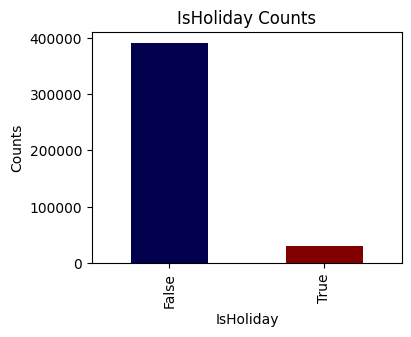

In [120]:
train_df['IsHoliday'].value_counts().plot(kind='bar',title="IsHoliday Counts",ylabel='Counts',\
                                          figsize=(4,3),color=mlt.colormaps['seismic'](np.linspace(0,2,2)))
plt.show()

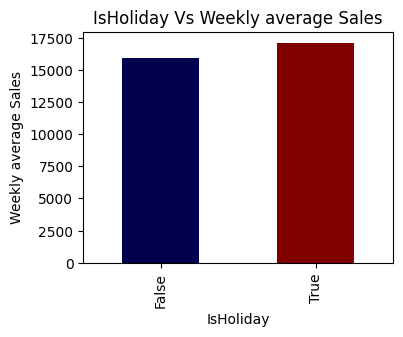

In [121]:
train_df.groupby("IsHoliday")["Weekly_Sales"].mean().plot(kind='bar',title="IsHoliday Vs Weekly average Sales",ylabel='Weekly average Sales',\
                                          figsize=(4,3),color=mlt.colormaps['seismic'](np.linspace(0,2,2)))
plt.show()

We can see the average weekly sales for Holiday days are more compared to non-holiday days, lets check the dates for the holiday days

In [122]:
holiday_dates = (train_df[train_df['IsHoliday']==True]['Date'].unique().strftime("%Y-%m-%d"))
holiday_dates

array(['2010-02-12', '2010-09-10', '2010-11-26', '2010-12-31',
       '2011-02-11', '2011-09-09', '2011-11-25', '2011-12-30',
       '2012-02-10', '2012-09-07'], dtype=object)

In [123]:
# We have total of 143 dates and 10 dates are holiday dates and remaining 133 are non-holiday dates
train_df['Date'].nunique() - len(holiday_dates)

133

The following are the common dates for these holidays:

Super Bowl: February 12, 2010; February 11, 2011; February 10, 2012; February 8, 2013

Labor Day: September 10, 2010; September 9, 2011; September 7, 2012; September 6, 2013

Thanksgiving: November 26, 2010; November 25, 2011; November 23, 2012; November 29, 2013

Christmas: December 31, 2010; December 30, 2011; December 28, 2012; December 27, 2013

After September 7, 2012, holidays fall into the test set for prediction. Analyzing the data reveals that average weekly sales are significantly higher on holidays compared to non-holiday days. In the training data, there are 133 weeks of non-holiday sales and 10 weeks of holiday sales.









In [124]:
# Column for Superbowl
superbowl_dates = [datetime(2010, 2, 12), datetime(2011, 2, 11), datetime(2012, 2, 10), datetime(2013, 2, 8)]
train_df["SuperBowl"] = train_df["Date"].isin(superbowl_dates)

# Column for LabourDay
christmas_dates = [datetime(2010, 9, 10), datetime(2011, 9, 9), datetime(2012, 9, 7), datetime(2013, 9, 6)]
train_df["LabourDay"] = train_df["Date"].isin(christmas_dates)

# Column for Thanksgiving
christmas_dates = [datetime(2010, 11, 26), datetime(2011, 11, 25), datetime(2012, 11, 23), datetime(2013, 11, 29)]
train_df["Thanksgiving"] = train_df["Date"].isin(christmas_dates)

# Column for Christmas
christmas_dates = [datetime(2010, 12, 31), datetime(2011, 12, 30), datetime(2012, 12, 28), datetime(2013, 12, 27)]
train_df["Christmas"] = train_df["Date"].isin(christmas_dates)

In [125]:
train_df[["SuperBowl", "LabourDay", "Thanksgiving", "Christmas"]].apply(pd.Series.value_counts)

,SuperBowl,LabourDay,Thanksgiving,Christmas
False,411339,411380,414266,414303
True,8873,8832,5946,5909


In [126]:

holiday_cols = ["SuperBowl", "LabourDay", "Thanksgiving", "Christmas"]
holiday_sales = {
    col: train_df.groupby(col)["Weekly_Sales"].mean() for col in holiday_cols
}
holiday_sales_df = pd.DataFrame(holiday_sales).T
holiday_sales_df.columns = ["Non-Holiday Sales", "Holiday Sales"]

tools.display_dataframe_to_user(name="Holiday vs Non-Holiday Weekly Avg Sales", dataframe=holiday_sales_df)


Holiday vs Non-Holiday Weekly Avg Sales


<Axes: title={'center': 'Avg Weekly sales Vs Holidays'}, ylabel='Weekly Avg Sales'>

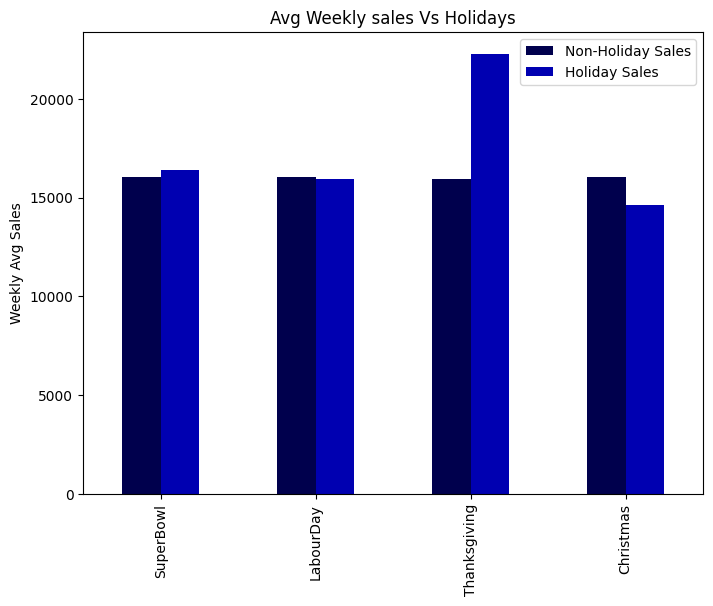

In [127]:
holiday_sales_df.plot(kind='bar',ylabel='Weekly Avg Sales',
                      title='Avg Weekly sales Vs Holidays',
                       figsize=(8,6),color=mlt.colormaps['seismic'](np.linspace(0,1,num=8)))

Thanksgiving drives the highest holiday sales, significantly surpassing non-holiday weeks, indicating peak consumer spending. Super Bowl and Labour Day sales remain stable, with only a slight increase during holidays. Christmas shows a unique trend, where non-holiday sales are higher, suggesting that most shopping happens before the holiday. Businesses should focus on Thanksgiving promotions, run early Christmas campaigns, and expect steady but not extreme sales growth during the Super Bowl and Labour Day periods.

**Type Effect on Holidays**

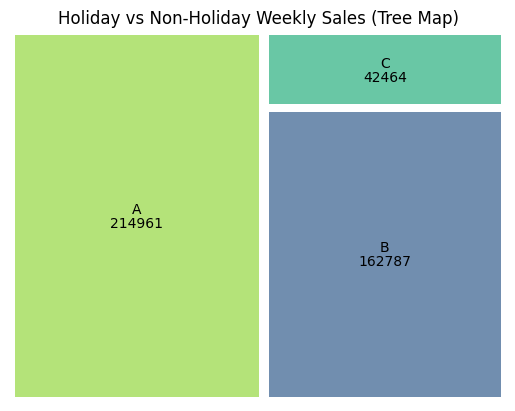

In [128]:
import squarify
sizes = train_df['Type'].value_counts().values
labels = train_df['Type'].value_counts().index

squarify.plot(sizes=sizes, label=labels, alpha=0.7,pad=1,value=sizes)
plt.axis("off")
plt.title("Holiday vs Non-Holiday Weekly Sales (Tree Map)")
plt.show()

In [129]:
holiday_sales_types = {
    col: train_df.groupby([col,'Type'],observed=False)["Weekly_Sales"].mean() for col in holiday_cols
}
holiday_sales_types_df = pd.DataFrame(holiday_sales_types).T
multi_index = holiday_sales_types_df.columns 
holiday_sales_types_df.columns  = multi_index.set_levels(
    [['Non-Holiday' if x is False else 'Holiday' for x in multi_index.levels[0]], multi_index.levels[1]],
    level=[0, 1]
) 

tools.display_dataframe_to_user(name="Holiday vs Type vs Non-Holiday Weekly Avg Sales", dataframe=holiday_sales_types_df)

Holiday vs Type vs Non-Holiday Weekly Avg Sales


In [130]:
holiday_sales_types_df_normalized = holiday_sales_types_df.stack(level=[0, 1],future_stack=True).reset_index()
holiday_sales_types_df_normalized.columns = ["Day", "Holiday", "Type", "Avg Weekly Sales"]
tools.display_dataframe_to_user(name="Normalized Holiday Sales Weekly Data", dataframe=holiday_sales_types_df_normalized)

Normalized Holiday Sales Weekly Data


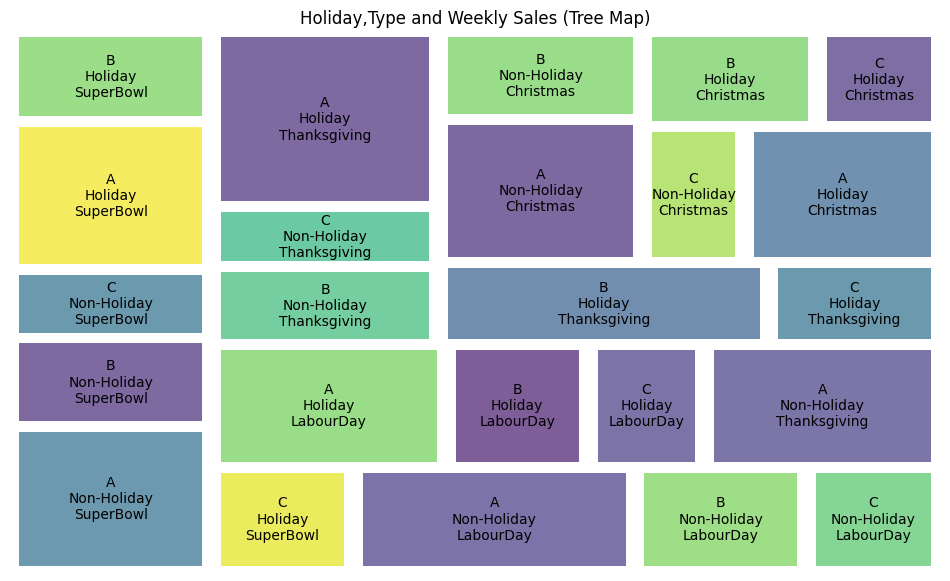

In [131]:
labels = [f"{t}\n{h}\n{d}" for t, h, d in zip(holiday_sales_types_df_normalized["Type"], \
                                            holiday_sales_types_df_normalized["Holiday"],\
                                            holiday_sales_types_df_normalized["Day"])]

# Extract sizes (Count values)
sizes = holiday_sales_types_df_normalized["Avg Weekly Sales"].tolist()

plt.figure(figsize=(12,7))
squarify.plot(sizes=sizes, label=labels, alpha=0.7,pad=1,text_kwargs={'fontsize': 10})
plt.axis("off")
plt.title("Holiday,Type and Weekly Sales (Tree Map)")
plt.show()

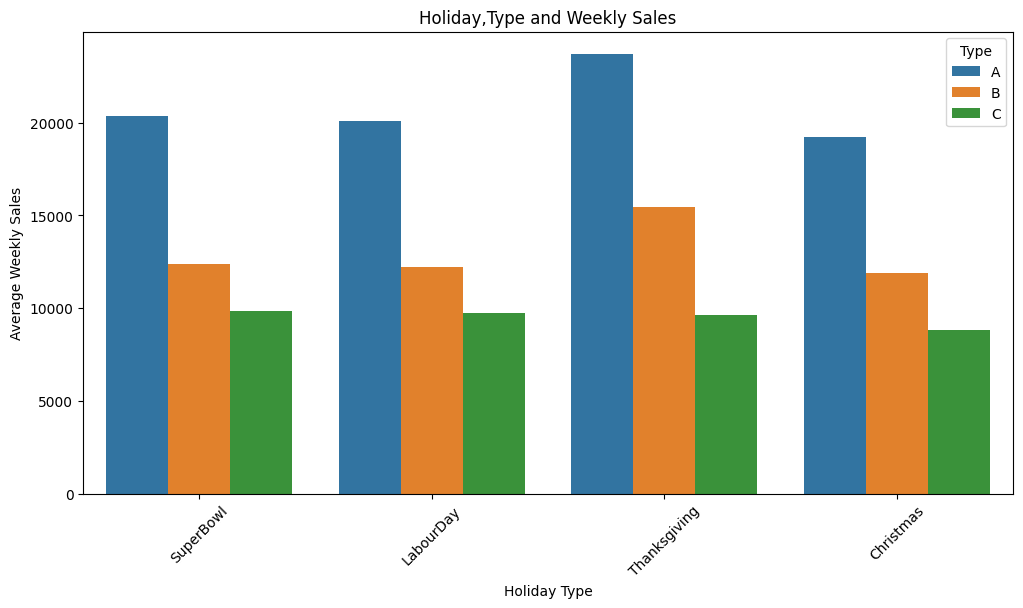

In [132]:
plt.figure(figsize=(12, 6))
sns.barplot(x="Day", y="Avg Weekly Sales", hue="Type", data=holiday_sales_types_df_normalized,errorbar=None)
plt.xlabel("Holiday Type")
plt.ylabel("Average Weekly Sales")
plt.title("Holiday,Type and Weekly Sales")
plt.xticks(rotation=45)
plt.show()

The analysis of Holiday, Type, and Weekly Sales reveals key insights into sales patterns across different holidays. The Tree Map highlights that Thanksgiving (Holiday) drives the highest weekly sales, as seen in the larger block sizes, while Christmas (Holiday) has relatively smaller blocks, suggesting that most shopping occurs before the actual holiday. Super Bowl and Labour Day exhibit a more balanced sales distribution, indicating stable demand. The Bar Chart further confirms that Type A consistently generates the highest weekly sales across all holidays, followed by Type B and Type C. Thanksgiving shows a significant sales boost compared to other holidays, reinforcing its importance for businesses. Interestingly, Christmas sales are lower during the holiday itself, implying that consumers shop in advance. These insights suggest that businesses should focus on Thanksgiving promotions to maximize revenue and launch early Christmas campaigns to capture pre-holiday shopping demand. 

**Type vs size relation**

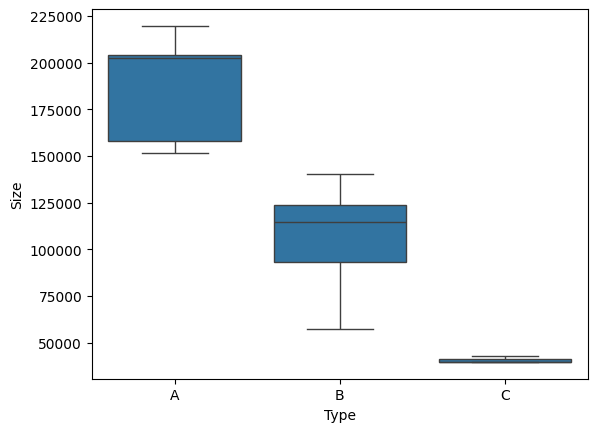

In [133]:
sns.boxplot(x='Type', y='Size', data=train_df, showfliers=False)
plt.show()

The box plot confirms that store size correlates with sales, as larger stores tend to generate higher revenue. Type A stores are the largest, with a wide range of sizes, followed by Type B stores, which have a smaller but still significant size distribution. Type C stores are the smallest and most consistent in size, suggesting that Walmart classifies stores based on their size categories. The transition between store types is clear: Type B stores begin where the smallest Type A store ends, and Type C stores start where the smallest Type B store ends. This structured classification likely helps optimize store operations and inventory planning. 

**Dept Weekly Sales**

<Axes: xlabel='Dept', ylabel='Weekly_Sales'>

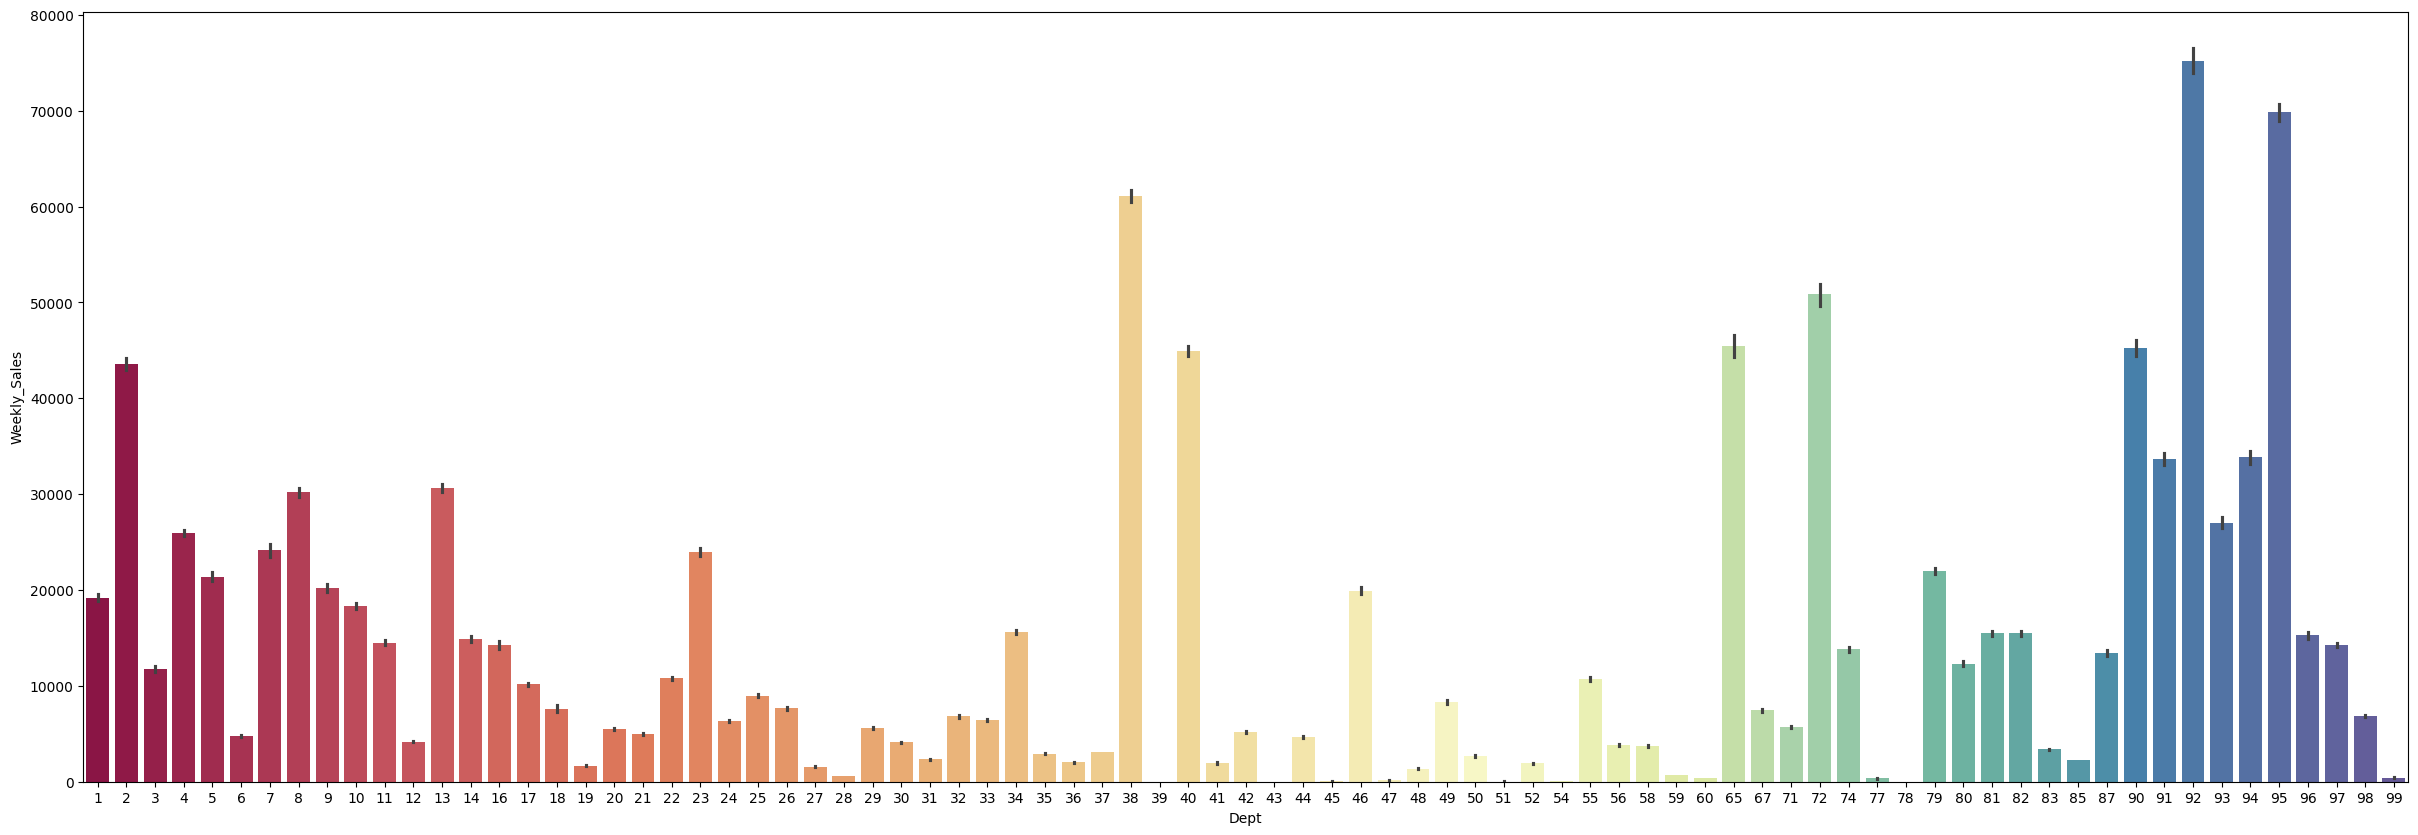

In [134]:
plt.figure(figsize=(30,10))
sns.barplot(x='Dept', y='Weekly_Sales', hue='Dept',legend=False,data=train_df,palette='Spectral') #estimator=mean

<Axes: xlabel='Dept', ylabel='Weekly_Sales'>

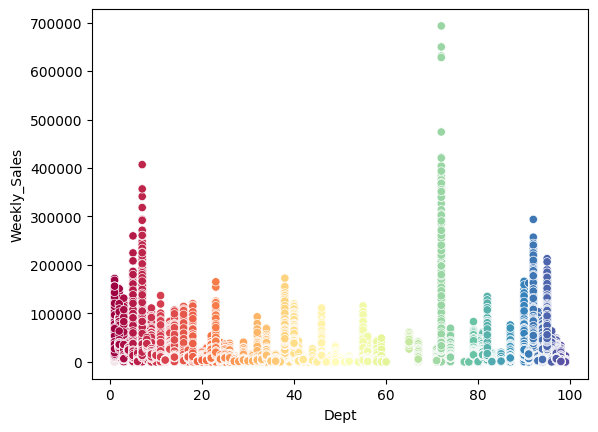

In [135]:
sns.scatterplot(x='Dept', y='Weekly_Sales', hue='Dept',legend=False,data=train_df,palette='Spectral')

This plot displays weekly sales by department, showing significant variation across different departments. Some departments, such as those around Dept 38, 60, 90, and 92, exhibit extremely high sales, suggesting they are critical revenue drivers. On the other hand, several smaller departments have consistently low sales, highlighting possible areas for optimization or promotional efforts. And dept 72 has highest value,maybe it is seasonal department which others are on average highest sale departments.

**Store Weekly Sales**

<Axes: xlabel='Store', ylabel='Weekly_Sales'>

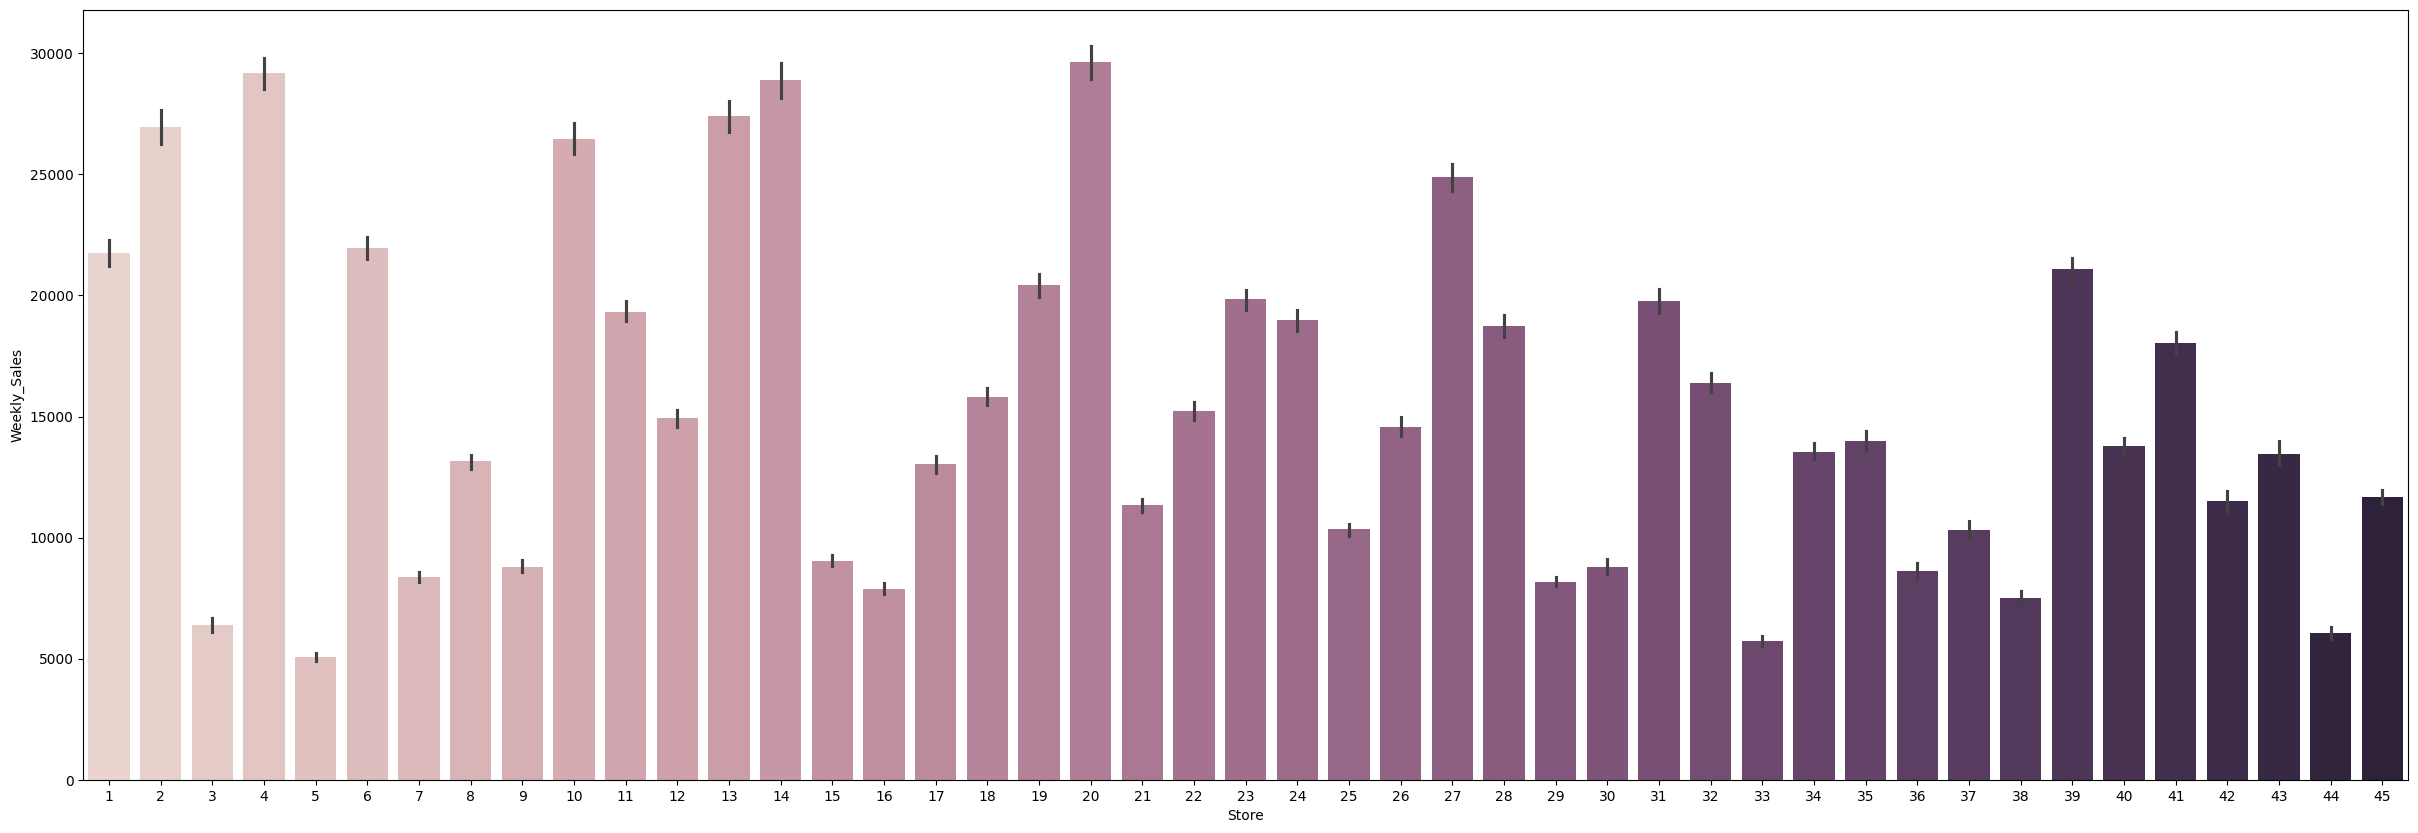

In [136]:
plt.figure(figsize=(30,10))
sns.barplot(x='Store', y='Weekly_Sales', hue='Store',legend=False,data=train_df) #estimator=mean

<Axes: xlabel='Store', ylabel='Weekly_Sales'>

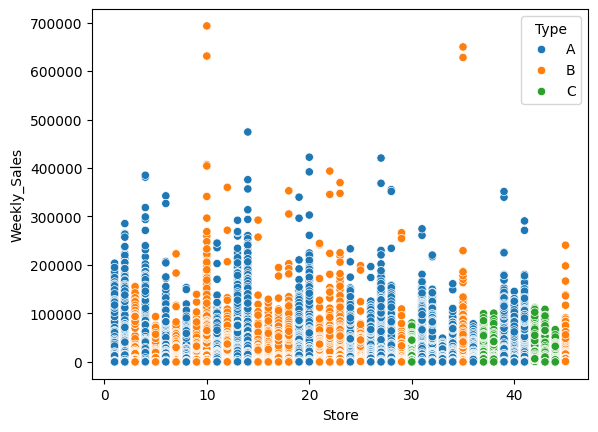

In [137]:
sns.scatterplot(x='Store', y='Weekly_Sales', hue='Type',data=train_df)

The bar chart shows variations in weekly sales across stores, with Stores 2, 4, 27, and 39 having the highest sales, while others maintain steady but lower sales, indicating location and store- specific factors influence revenue. The scatter plot further breaks down sales by store type, showing Type A stores (blue) dominate in sales, followed by Type B (orange) and Type C (green), which has the lowest sales. The presence of high value outliers in Type A and B suggests that certain stores experience exceptionally high sales peaks, emphasizing the role of store classification in revenue optimization.

**Weekly Sales with time period**

<Axes: xlabel='Month', ylabel='Weekly_Sales'>

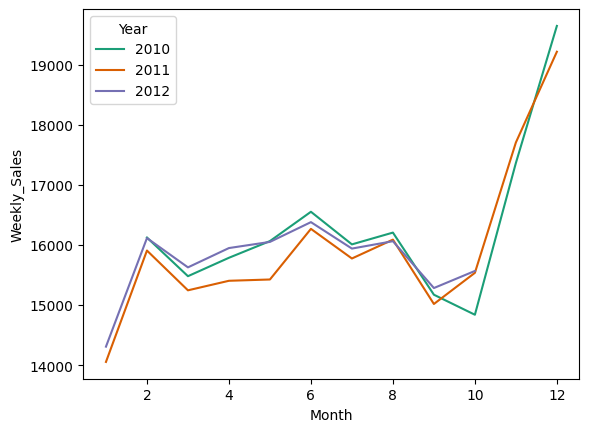

In [138]:
sns.lineplot(train_df,x='Month',y='Weekly_Sales',hue='Year',errorbar=None,palette='Dark2')

<Axes: xlabel='Week', ylabel='Weekly_Sales'>

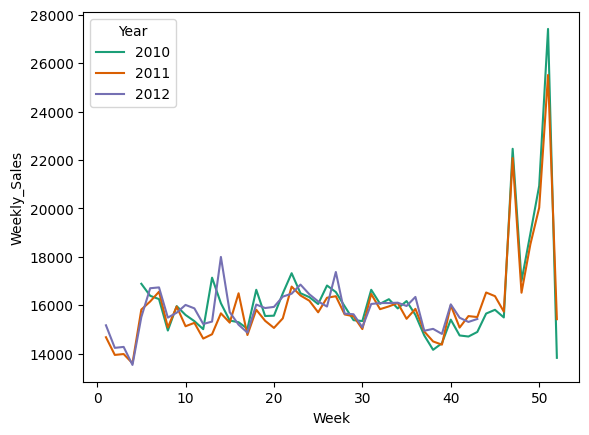

In [139]:
sns.lineplot(train_df,x='Week',y='Weekly_Sales',hue='Year',errorbar=None,palette='Dark2')

<Axes: xlabel='Week', ylabel='Weekly_Sales'>

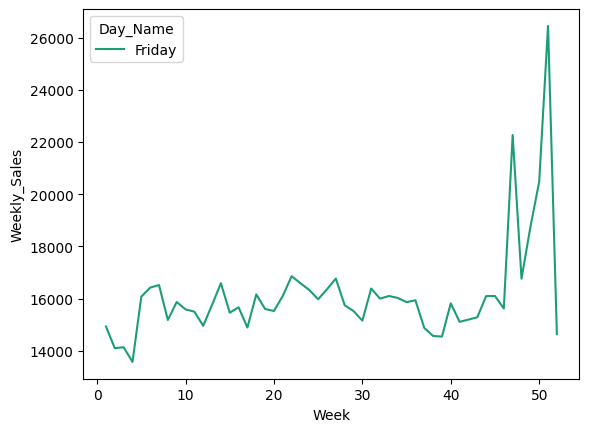

In [140]:
sns.lineplot(train_df,x='Week',y='Weekly_Sales',hue='Day_Name',errorbar=None,palette='Dark2')

In [141]:
#dropping the Day_Name column 
train_df.drop(columns=['Day_Name','Day_of_Week'],inplace=True)

**Weekly sales with other features**

<Axes: xlabel='Temperature', ylabel='Weekly_Sales'>

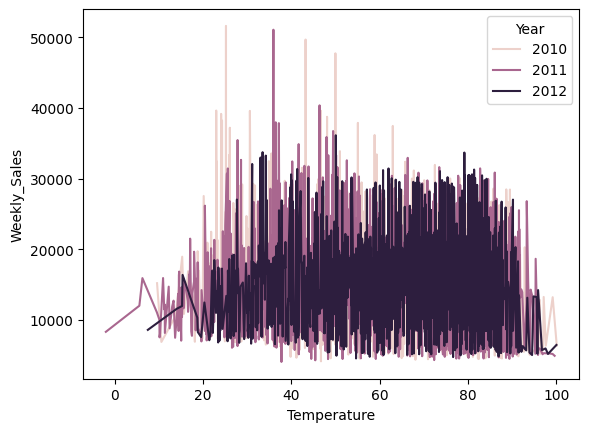

In [142]:
sns.lineplot(train_df,x='Temperature',y='Weekly_Sales',hue='Year',errorbar=None)

<Axes: xlabel='Fuel_Price', ylabel='Weekly_Sales'>

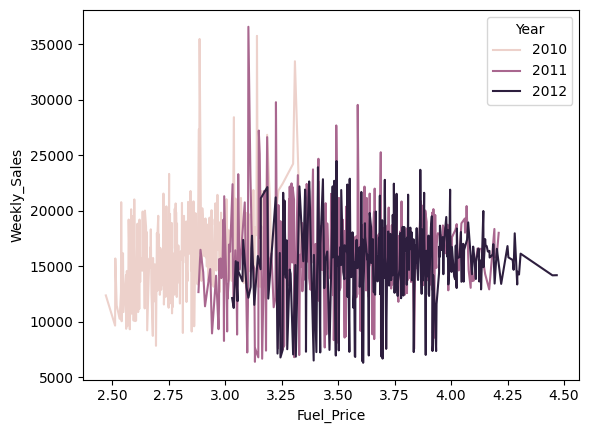

In [143]:
sns.lineplot(train_df,x='Fuel_Price',y='Weekly_Sales',hue='Year',errorbar=None)

<Axes: xlabel='CPI', ylabel='Weekly_Sales'>

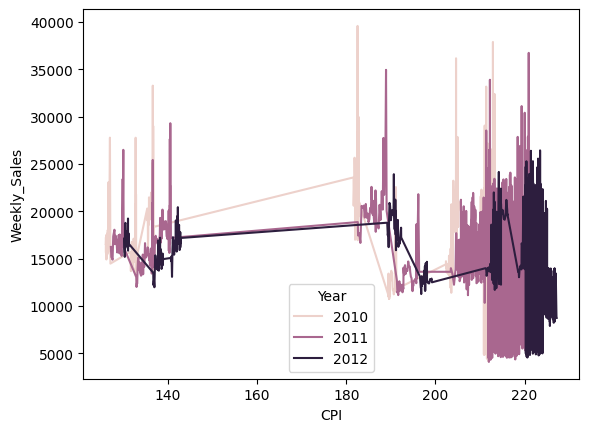

In [144]:
sns.lineplot(train_df,x='CPI',y='Weekly_Sales',hue='Year',errorbar=None)

<Axes: xlabel='Unemployment', ylabel='Weekly_Sales'>

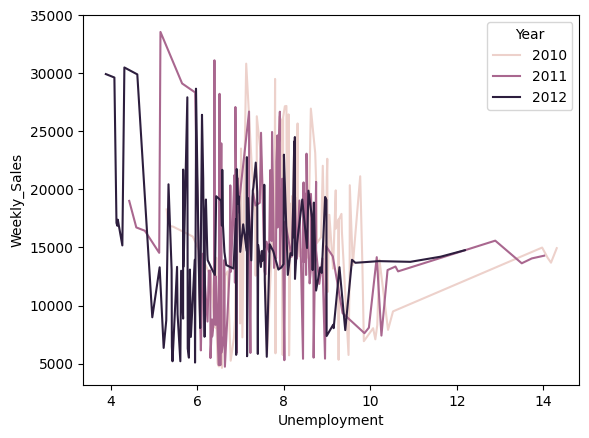

In [145]:
sns.lineplot(train_df,x='Unemployment',y='Weekly_Sales',hue='Year',errorbar=None)

From graphs, it is seen that there are no significant patterns between CPI, temperature, unemployment rate, fuel price vs weekly sales.


In [146]:
dtypes = train_df.dtypes.astype(str) #data types for cleaned dataframe
train_df.to_csv('../data/cleaned_data.csv',index=None) #store cleaned dataframe
dtypes.to_csv("dtypes.csv", index=True,header=None)


In [147]:
dtypes

Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                 bool
Type                  category
Size                     int64
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
Year                     int32
Month                    int32
Day                      int32
Week                    UInt32
SuperBowl                 bool
LabourDay                 bool
Thanksgiving              bool
Christmas                 bool
dtype: object

In [204]:
df = pd.read_csv('../data/cleaned_data.csv')

dtype_mapping = pd.read_csv("dtypes.csv", index_col=0,header=None).to_dict()[1]

# Convert dtypes back to original format
for col, dtype in dtype_mapping.items():
    df[col] = df[col].astype(dtype)

df.head(2)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,...,CPI,Unemployment,Year,Month,Day,Week,SuperBowl,LabourDay,Thanksgiving,Christmas
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,0.0,...,211.096358,8.106,2010,2,5,5,False,False,False,False
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,0.0,...,211.242170,8.106,2010,2,12,6,True,False,False,False


**Encode the data**

In [205]:
type_group = {'A':1, 'B': 2, 'C': 3}
df['Type'] = df['Type'].map(type_group).astype(int)

for col in holiday_cols+(['IsHoliday']):
    df[col] = df[col].astype(int) 

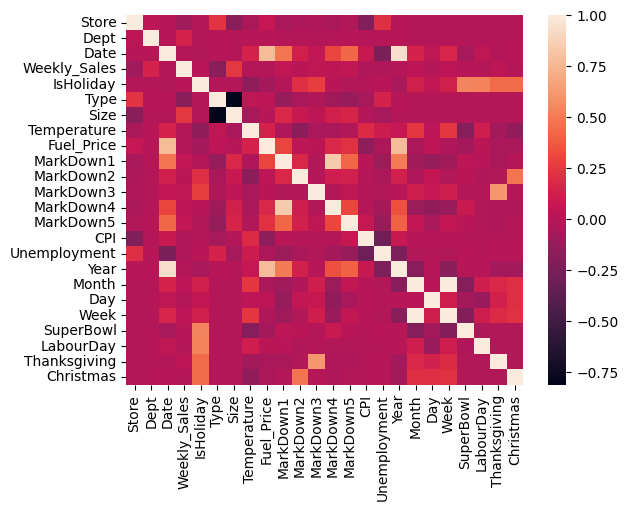

In [206]:
sns.heatmap(df.corr())
plt.show()

<Axes: >

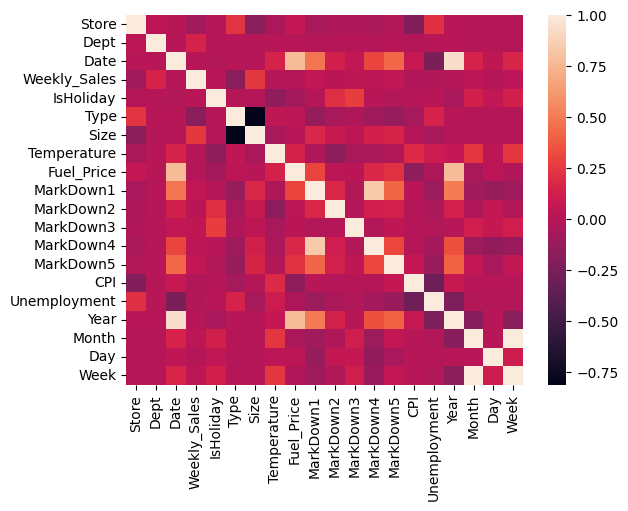

In [207]:
sns.heatmap(df.drop(holiday_cols, axis=1).corr())

In [208]:
# drop_col = ['Temperature','MarkDown4','MarkDown5','CPI','Unemployment']
# df.drop(drop_col, axis=1, inplace=True) # dropping columns

**Model implementation**

In [153]:
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error,accuracy_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression 
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler,StandardScaler

In [154]:
def split_data(df,split_ratio,target_column):
    train_data = df[:-(int(split_ratio*(len(df))))]
    test_data = df[-(int(split_ratio*len(df))):]

    feature_cols = [col for col in df.columns if col!=target_column ]

    X_train,Y_train = train_data[feature_cols],train_data[target_column]
    X_test,Y_test = test_data[feature_cols],test_data[target_column]

    return X_train,X_test,Y_train,Y_test

In [155]:
X_train,X_test,Y_train,Y_test = split_data(df,split_ratio=0.25,target_column="Weekly_Sales")

In [156]:
X_train.shape,X_test.shape

((315159, 23), (105053, 23))

The wmae_test function calculates the Weighted Mean Absolute Error (WMAE), where errors on holidays are given 5x more weight than non-holidays. It computes the absolute difference between actual (test) and predicted (pred) values, multiplies them by weights (based on IsHoliday in X_test), sums the weighted errors, and normalizes by the total weights. This metric ensures holiday errors have a higher impact in evaluating model performance, making it ideal for retail and sales forecasting.

In [157]:
def wmae_test(test, pred): # WMAE for test 
    weights = X_test['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
    error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
    return error.item()
def mae_test(test,pred):
    return mean_absolute_error(test,pred)

In [158]:
def plot_feature_importances(model_,X):

    # Get feature importance scores and standard deviations
    importances = model_.feature_importances_
    std_devs = np.std([tree.feature_importances_ for tree in model_.estimators_], axis=0)
    feature_names = X.columns

    # Sort feature indices by importance
    sorted_indices = np.argsort(importances)[::-1]
    sorted_features = feature_names[sorted_indices]
    
    print("Feature Ranking:")
    for rank, (feature, importance) in enumerate(zip(sorted_features, importances[sorted_indices]), start=1):
        print(f"{rank}. {feature} (Importance: {importance:.6f})")

    # Plot feature importances
    plt.figure(figsize=(10, 5))
    plt.title("Feature Importances")
    plt.bar(range(X.shape[1]), importances[sorted_indices], yerr=std_devs[sorted_indices], 
            color=mlt.colormaps['Set3'](np.linspace(0,1,len(importances))), align="center")
    plt.xticks(range(X.shape[1]), sorted_features, rotation=45, ha="right")
    plt.xlabel("Feature Index")
    plt.ylabel("Importance Score")
    plt.xlim([-1, X.shape[1]])
    plt.show()

        

In [159]:
def model(X_train,X_test,Y_train,Y_test,drop_col=[],model_name='',scaler=''):

    X_train,X_test = X_train.drop(columns=drop_col,axis=1),X_test.drop(columns=drop_col,axis=1)

    if scaler == 'Robust Scaler':
        scaler = RobustScaler()
    elif scaler == 'Standard Scaler':
        scaler = StandardScaler()
    else:
        scaler = StandardScaler()

    if model_name == 'Random Forest':
        # Define the regressor
        regressor = RandomForestRegressor(
            n_estimators=50, 
            random_state=42, 
            n_jobs=-1, 
            max_depth=35,
            max_features='sqrt', 
            min_samples_split=10
        )
    else:
        regressor = RandomForestRegressor()

    # Create a pipeline combining the scaler and regressor
    pipeline = Pipeline([
        ('scaler', scaler),
        ('regressor', regressor)
    ])

    # Train the model
    pipeline.fit(X_train, Y_train)

    # Make predictions
    y_train_pred = pipeline.predict(X_train)  # Predictions on training set
    y_test_pred = pipeline.predict(X_test)    # Predictions on test set

    return y_train_pred,y_test_pred,regressor


In [160]:
def get_results(model_name,info,wmae_score,mae_score,results):
    results.append({
        'Model_name':model_name,
        'Info':info,
        'wmae_score':wmae_score,
        'mae_score':mae_score
    })

    return results

In [161]:
results = []

In [162]:
# dropping these columns because these doesnt show any correlation pattern with target variable
drop_col = ['Date']
model_name = 'Random Forest'
info = "With all features"
train_preds,test_preds,model_ = model(X_train,X_test,Y_train,Y_test,drop_col,'Random Forest','Robust Scaler')
wmae_score = wmae_test(Y_test,test_preds)
mae_score = mae_test(Y_test,test_preds)
wmae_score,mae_score

python(88821) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


(6944.1835422596, 6685.050929579073)

In [163]:
# dropping these columns because these doesnt show any correlation pattern with target variable
drop_col = ['Date']
model_name = 'Random Forest'
info = "With all features"
train_preds,test_preds,model_ = model(X_train,X_test,Y_train,Y_test,drop_col,'Random Forest','Standard Scaler')
wmae_score = wmae_test(Y_test,test_preds)
mae_score = mae_test(Y_test,test_preds)
results = get_results(model_name,info,wmae_score,mae_score,results)
wmae_score,mae_score

(6914.42231275656, 6657.356241354551)

Feature Ranking:
1. Dept (Importance: 0.738183)
2. Size (Importance: 0.096869)
3. Store (Importance: 0.033516)
4. Type (Importance: 0.026800)
5. CPI (Importance: 0.025097)
6. Unemployment (Importance: 0.016266)
7. Week (Importance: 0.011303)
8. Temperature (Importance: 0.010324)
9. Fuel_Price (Importance: 0.008629)
10. Day (Importance: 0.007391)
11. Month (Importance: 0.004993)
12. MarkDown3 (Importance: 0.004442)
13. MarkDown5 (Importance: 0.003669)
14. MarkDown1 (Importance: 0.003098)
15. MarkDown4 (Importance: 0.002981)
16. MarkDown2 (Importance: 0.002269)
17. Thanksgiving (Importance: 0.001142)
18. Year (Importance: 0.001103)
19. IsHoliday (Importance: 0.000904)
20. Christmas (Importance: 0.000523)
21. SuperBowl (Importance: 0.000290)
22. LabourDay (Importance: 0.000208)


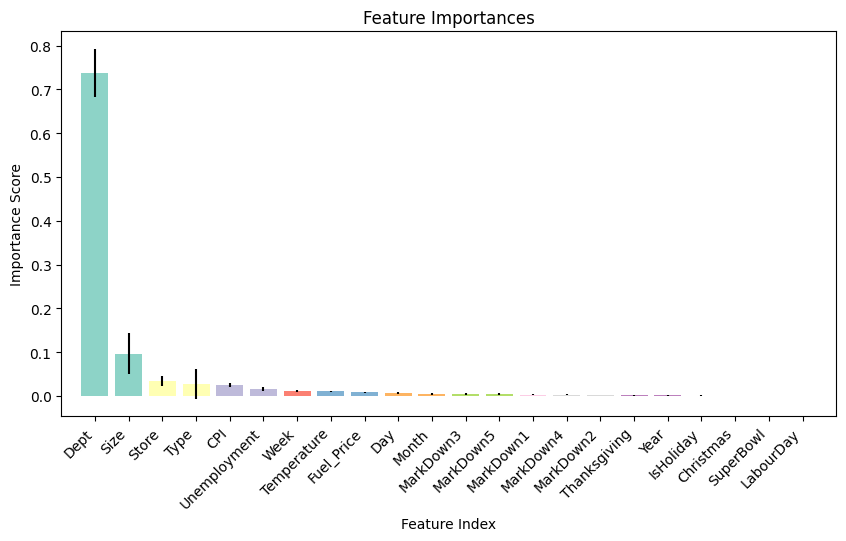

In [164]:
plot_feature_importances(model_,X_train.drop(columns=drop_col,axis=1))

In [165]:
# dropping holiday column
drop_col = ['Date'] + holiday_cols
model_name = 'Random Forest'
info = "Feature selection w/o seperate holiday column"
train_preds,test_preds,model_ = model(X_train,X_test,Y_train,Y_test,drop_col,'Random Forest','Robust Scaler')
wmae_score = wmae_test(Y_test,test_preds)
mae_score = mae_test(Y_test,test_preds)
wmae_score,mae_score

(6600.901972029768, 6389.935355837471)

Feature Ranking:
1. Dept (Importance: 0.747934)
2. Size (Importance: 0.072987)
3. Type (Importance: 0.043863)
4. Store (Importance: 0.034568)
5. CPI (Importance: 0.024870)
6. Unemployment (Importance: 0.015737)
7. Week (Importance: 0.011152)
8. Temperature (Importance: 0.009571)
9. Fuel_Price (Importance: 0.008032)
10. Day (Importance: 0.007425)
11. Month (Importance: 0.005466)
12. MarkDown3 (Importance: 0.004412)
13. MarkDown5 (Importance: 0.003635)
14. MarkDown1 (Importance: 0.002975)
15. MarkDown4 (Importance: 0.002968)
16. MarkDown2 (Importance: 0.002126)
17. IsHoliday (Importance: 0.001182)
18. Year (Importance: 0.001096)


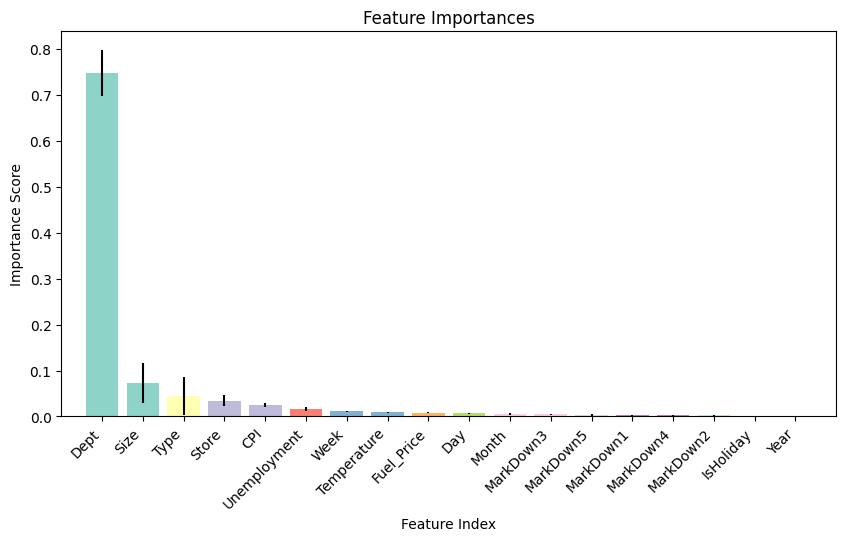

In [166]:
plot_feature_importances(model_,X_train.drop(columns=drop_col,axis=1))

In [167]:
drop_col = ['Date','MarkDown1','MarkDown2','MarkDown4','MarkDown5','Year'] + holiday_cols
model_name = 'Random Forest'
info = "Feature selection without seperate holiday columns plus no correlation columns"
train_preds,test_preds,model_ = model(X_train,X_test,Y_train,Y_test,drop_col+holiday_cols,'Random Forest','Standard Scaler')
wmae_score = wmae_test(Y_test,test_preds)
results = get_results(model_name,info,wmae_score,mae_score,results)
mae_score = mae_test(Y_test,test_preds)
wmae_score,mae_score

(6414.940570357783, 6181.291904299407)

Feature Ranking:
1. Dept (Importance: 0.749198)
2. Size (Importance: 0.073233)
3. Type (Importance: 0.045101)
4. Store (Importance: 0.033739)
5. CPI (Importance: 0.027137)
6. Unemployment (Importance: 0.017208)
7. Week (Importance: 0.012242)
8. Temperature (Importance: 0.010730)
9. Fuel_Price (Importance: 0.009542)
10. Day (Importance: 0.008371)
11. MarkDown3 (Importance: 0.006508)
12. Month (Importance: 0.005686)
13. IsHoliday (Importance: 0.001304)


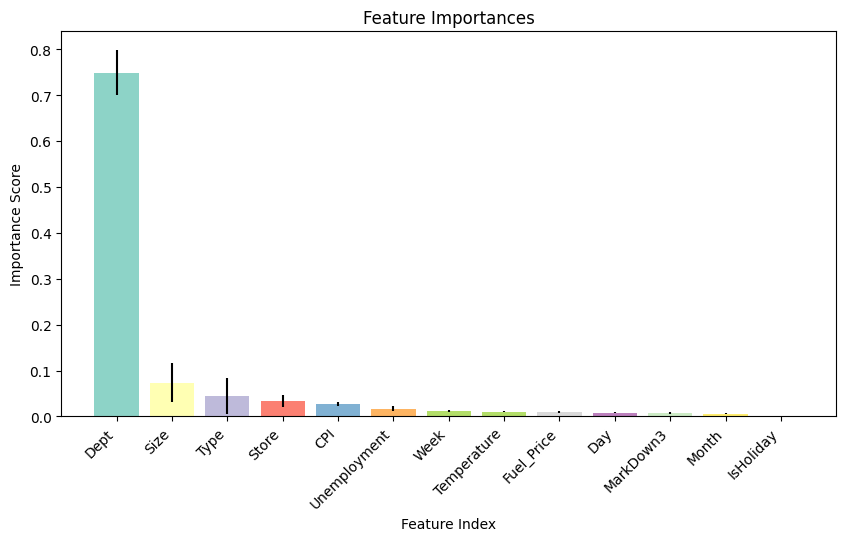

In [168]:
plot_feature_importances(model_,X_train.drop(columns=drop_col,axis=1))

In [169]:
drop_col = ['Date','MarkDown1','MarkDown2','MarkDown4','MarkDown5','Year','Fuel_Price','Temperature','CPI','Unemployment'] + holiday_cols
model_name = 'Random Forest'
info = "Feature selection without seperate holiday columns plus more no correlation columns"
train_preds,test_preds,model_ = model(X_train,X_test,Y_train,Y_test,drop_col+holiday_cols,'Random Forest','Standard Scaler')
wmae_score = wmae_test(Y_test,test_preds)
mae_score = mae_test(Y_test,test_preds)
results = get_results(model_name,info,wmae_score,mae_score,results)
wmae_score,mae_score

(4689.276666624219, 4520.135041908409)

Feature Ranking:
1. Dept (Importance: 0.736245)
2. Size (Importance: 0.115855)
3. Store (Importance: 0.057205)
4. Type (Importance: 0.038495)
5. Week (Importance: 0.019167)
6. Day (Importance: 0.012187)
7. Month (Importance: 0.009729)
8. MarkDown3 (Importance: 0.009458)
9. IsHoliday (Importance: 0.001659)


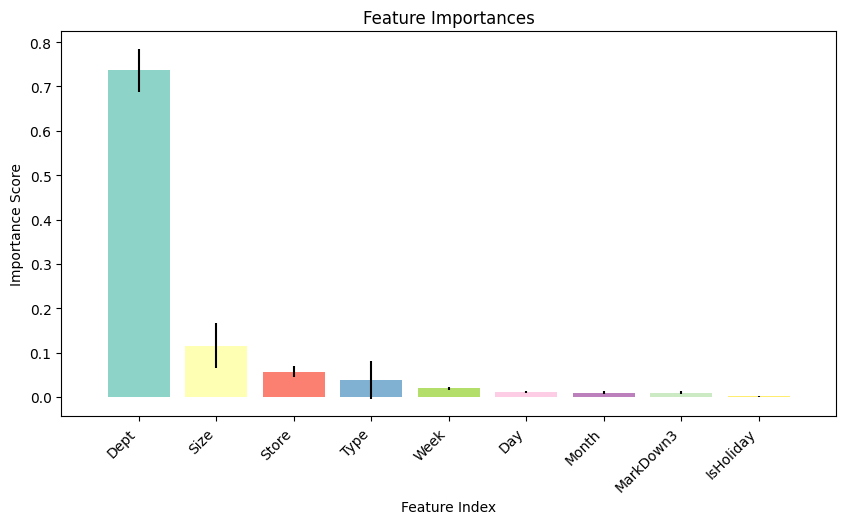

In [170]:
plot_feature_importances(model_,X_train.drop(columns=drop_col,axis=1))

In [171]:
drop_col = ['Date','MarkDown1','MarkDown2','MarkDown4','MarkDown5',\
            'Year','Fuel_Price','Temperature','CPI','Unemployment','Month'] + holiday_cols
model_name = 'Random Forest'
info = "Feature selection without seperate holiday columns,Month plus more no correlation columns"
train_preds,test_preds,model_ = model(X_train,X_test,Y_train,Y_test,drop_col+holiday_cols,'Random Forest','Standard Scaler')
wmae_score = wmae_test(Y_test,test_preds)
mae_score = mae_test(Y_test,test_preds)
results = get_results(model_name,info,wmae_score,mae_score,results)
wmae_score,mae_score

(5165.866399735026, 4889.261626909788)

Feature Ranking:
1. Dept (Importance: 0.759517)
2. Size (Importance: 0.090867)
3. Store (Importance: 0.053959)
4. Type (Importance: 0.044116)
5. Week (Importance: 0.023881)
6. Day (Importance: 0.013583)
7. MarkDown3 (Importance: 0.012475)
8. IsHoliday (Importance: 0.001602)


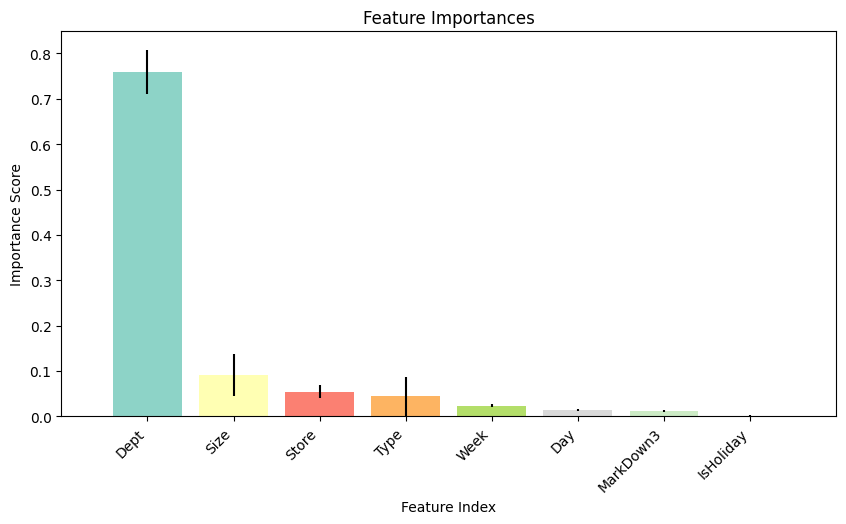

In [172]:
plot_feature_importances(model_,X_train.drop(columns=drop_col,axis=1))

In [173]:
tools.display_dataframe_to_user(name="Model results", dataframe=pd.DataFrame(results).sort_values(by=['wmae_score'])) 

Model results


#### Time Series

In [209]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose as season
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [210]:
df.set_index('Date', inplace=True)

In [211]:
df.index

DatetimeIndex(['2010-02-05', '2010-02-12', '2010-02-19', '2010-02-26',
               '2010-03-05', '2010-03-12', '2010-03-19', '2010-03-26',
               '2010-04-02', '2010-04-09',
               ...
               '2012-08-24', '2012-08-31', '2012-09-07', '2012-09-14',
               '2012-09-21', '2012-09-28', '2012-10-05', '2012-10-12',
               '2012-10-19', '2012-10-26'],
              dtype='datetime64[ns]', name='Date', length=420212, freq=None)

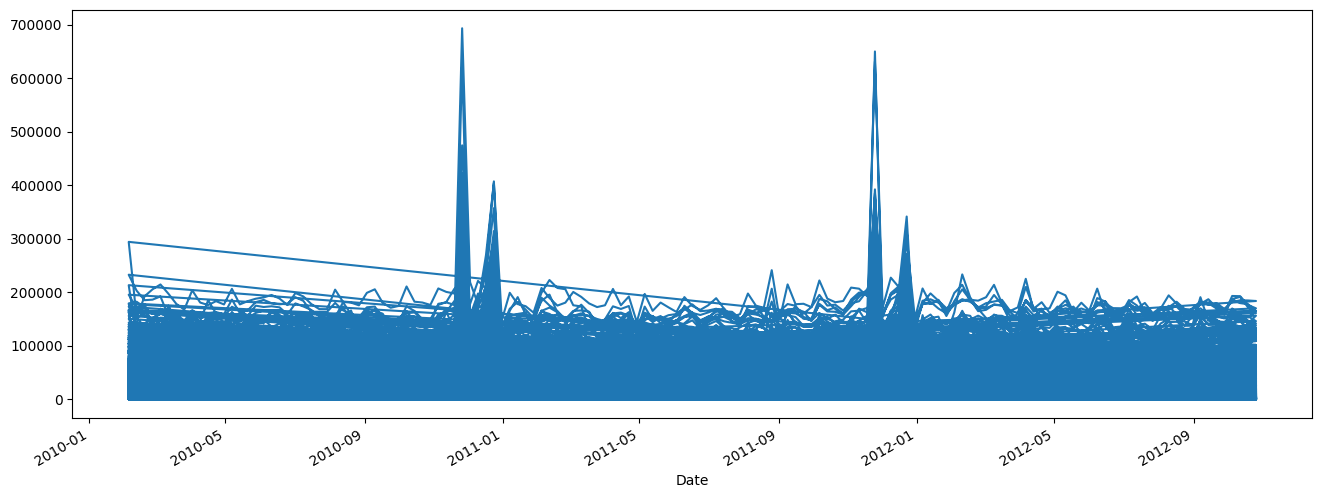

In [212]:
plt.figure(figsize=(16,6))
df['Weekly_Sales'].plot()
plt.show()

In [213]:
df_week = df.resample('W').mean() #resample data as weekly


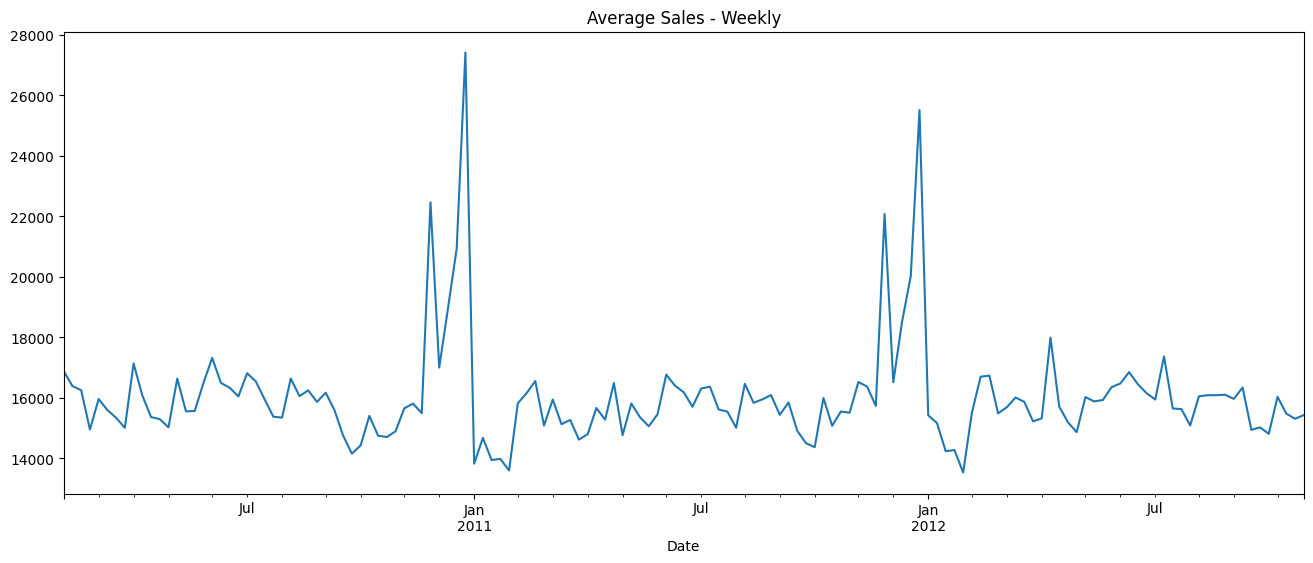

In [214]:
plt.figure(figsize=(16,6))
df_week['Weekly_Sales'].plot()
plt.title('Average Sales - Weekly')
plt.show()

In [215]:
df_month = df.resample('MS').mean() # resampling as monthly

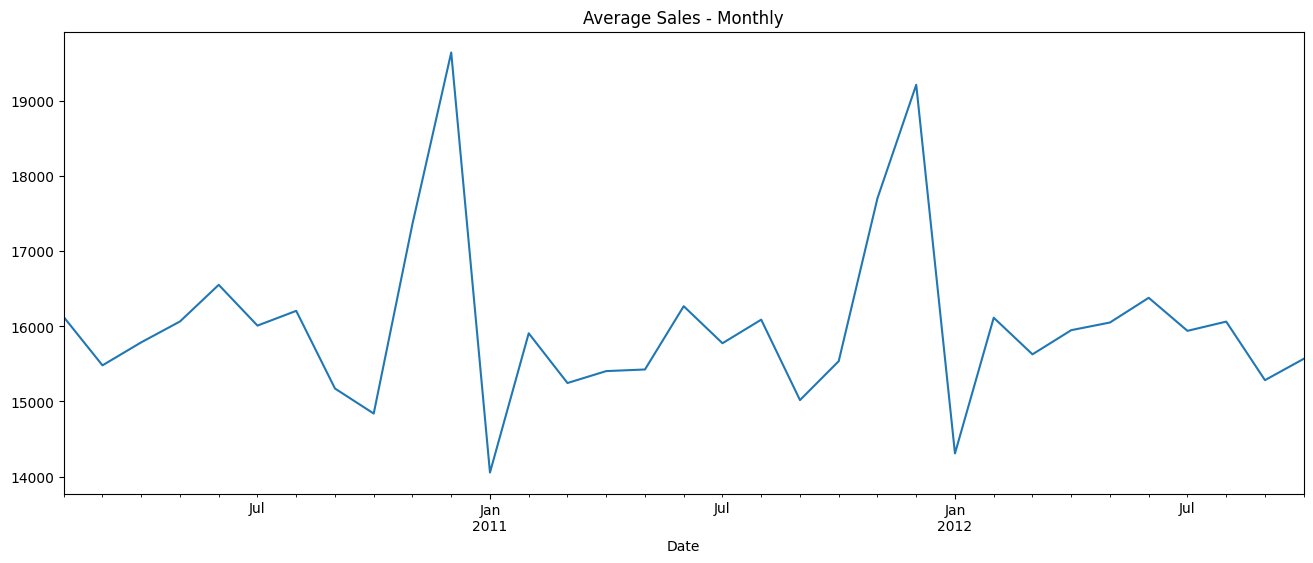

In [216]:
plt.figure(figsize=(16,6))
df_month['Weekly_Sales'].plot()
plt.title('Average Sales - Monthly')
plt.show()

As you can see the data for weekly and monthly are non-stationary, weekly data seems more accurate for forecasting as you can see we have lost some data for monthly resampling.

In [217]:
# finding 2-weeks rolling mean and std
roll_mean = df_week['Weekly_Sales'].rolling(window=2, center=False).mean()
roll_std = df_week['Weekly_Sales'].rolling(window=2, center=False).std()


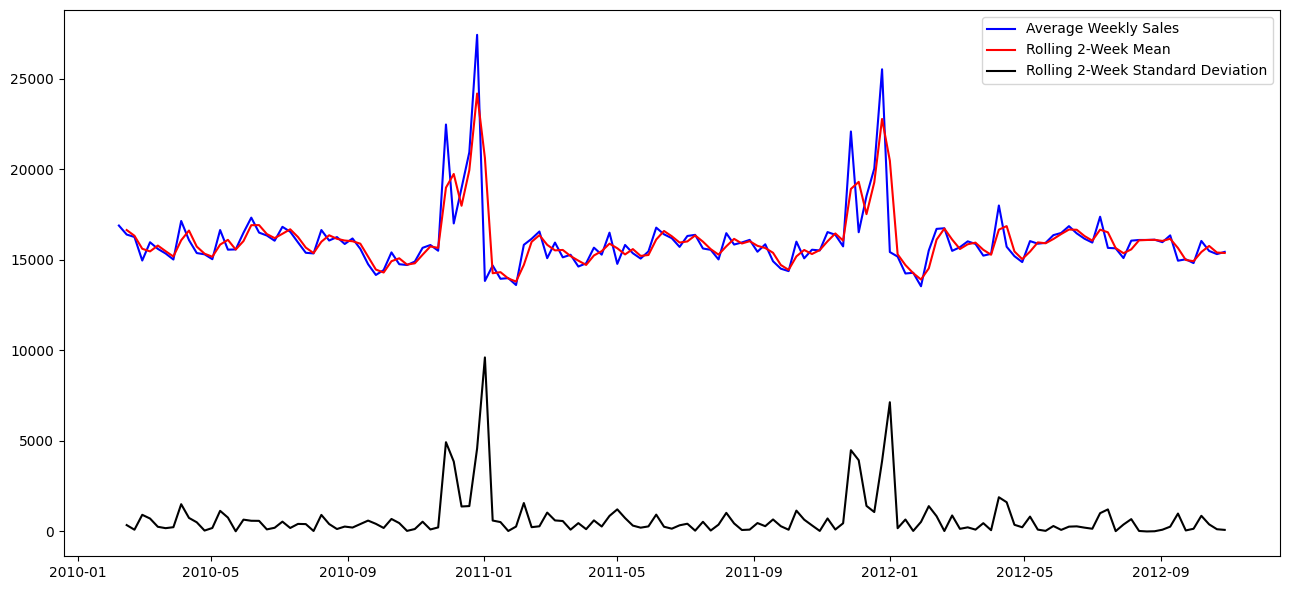

In [218]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week['Weekly_Sales'], color='blue',label='Average Weekly Sales')
ax.plot(roll_mean, color='red', label='Rolling 2-Week Mean')
ax.plot(roll_std, color='black', label='Rolling 2-Week Standard Deviation')
ax.legend()
fig.tight_layout()

We can see the mean and standard deviation both are non-stationary, we can perform ADF test to verify this

In [219]:
adfuller(df_week['Weekly_Sales'])

(-5.927107223737573,
 2.429049208204236e-07,
 4,
 138,
 {'1%': -3.47864788917503,
  '5%': -2.882721765644168,
  '10%': -2.578065326612056},
 2261.596421168073)

The Augmented Dickey-Fuller (ADF) test results indicate that the p-value is extremely low (2.42e-07), which is far below the 5% significance level. This suggests that we can reject the null hypothesis (H₀) that the series has a unit root, meaning that the Weekly_Sales data is stationary. The test statistic (-5.927) is also lower than all critical values (-3.478 at 1%, -2.882 at 5%, -2.578 at 10%), further confirming stationarity. Since stationarity is essential for time series modeling (e.g., ARIMA), no additional differencing is needed before applying forecasting models. But still we see some spikes in certain intervals that may include seasonality.

Lets plot the autocorrelation and Partial autocorrelation curves to check for stationarity and to get the order for AR(p) and MA(q) models, and d=0 because differencing maynot be required for this problem.

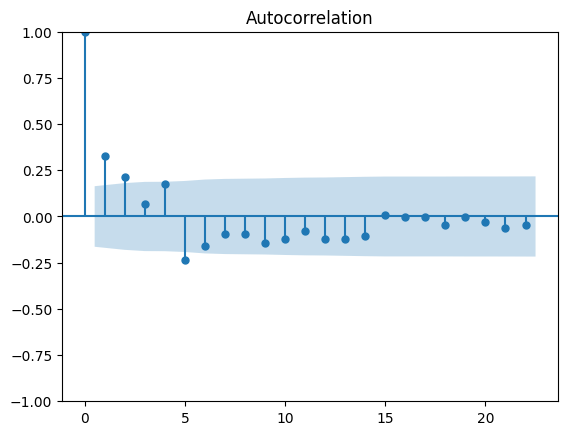

In [220]:
# ACF plot
plot_acf(df_week['Weekly_Sales'])
plt.show()

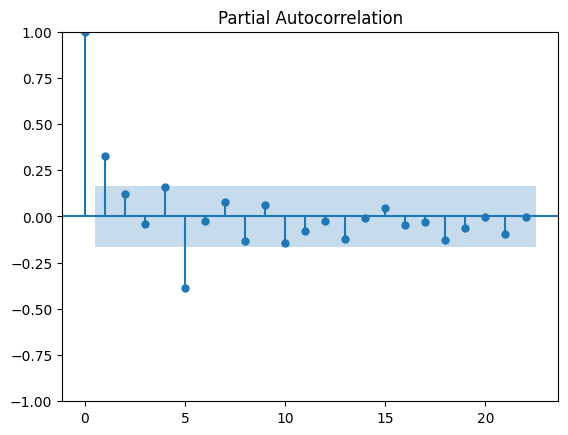

In [221]:
# PACF plot
plot_pacf(df_week['Weekly_Sales'])
plt.show()

In [222]:
train_data = df_week[:int(0.7*(len(df_week)))] 
test_data = df_week[int(0.7*(len(df_week))):]

print('Train:', train_data.shape)
print('Test:', test_data.shape)

Train: (100, 23)
Test: (43, 23)


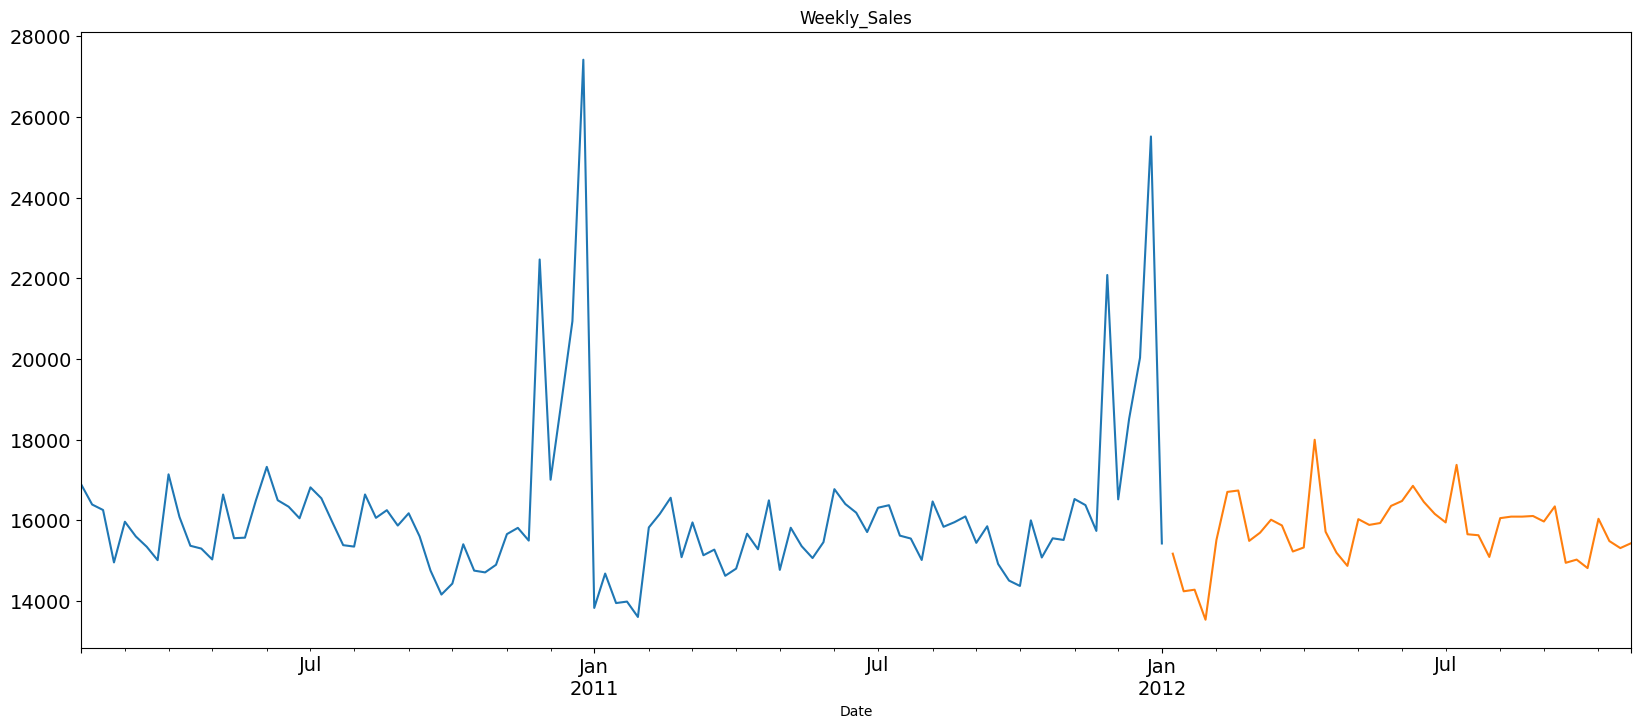

In [223]:
target_column = "Weekly_Sales"
feature_cols = [col for col in df.columns if col!=target_column ]

X_train,Y_train = train_data[feature_cols],train_data[target_column]
X_test,Y_test = test_data[feature_cols],test_data[target_column]

train_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
test_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
plt.show()

### Decomposing Weekly Data to Observe Seasonality

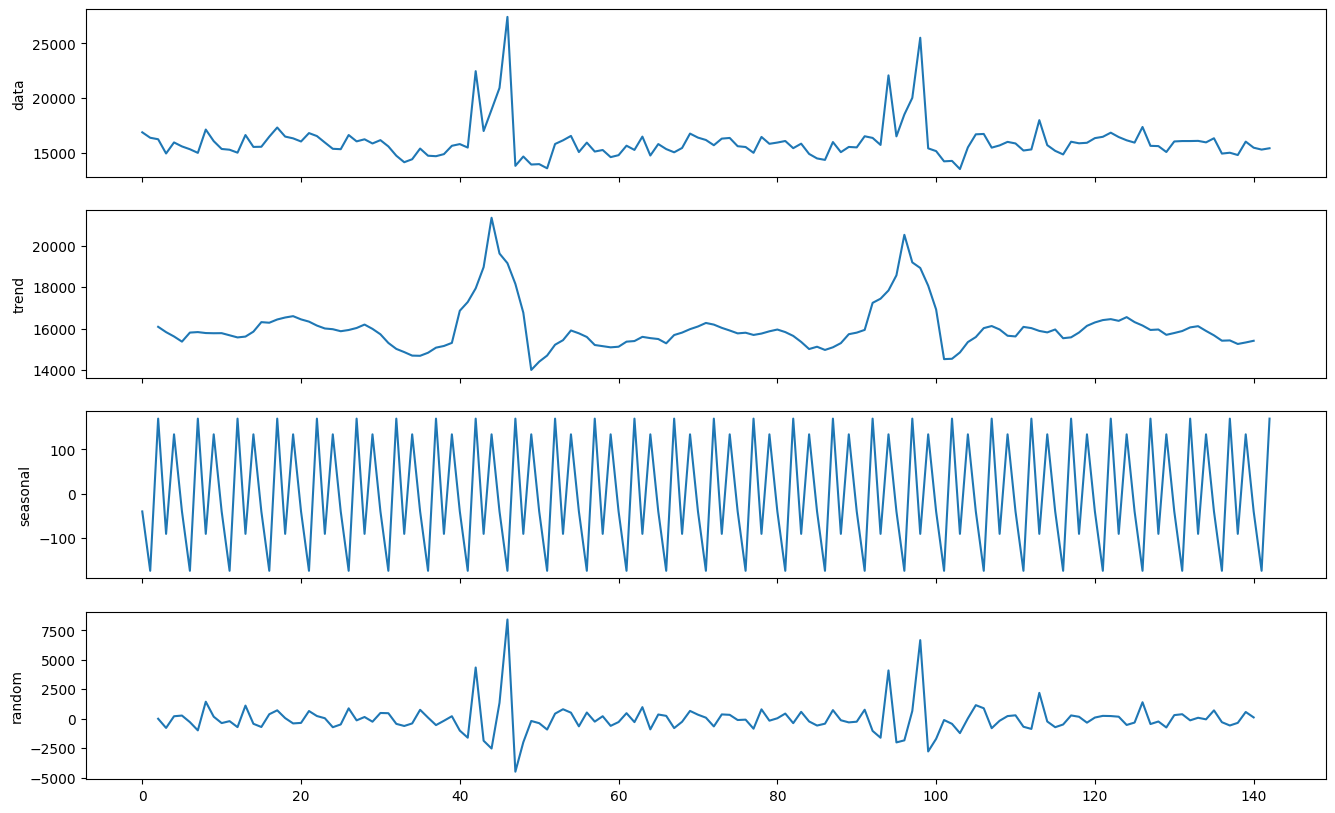

In [224]:
decomposed = decompose(df_week['Weekly_Sales'].values, 'additive', m=5) #decomposing of weekly data 
decomposed_plot(decomposed, figure_kwargs={'figsize': (16, 10)})
plt.show()

### Trying To Make Data More Stationary

1. Difference

In [251]:
df_week_diff = df_week['Weekly_Sales'].diff().dropna() 

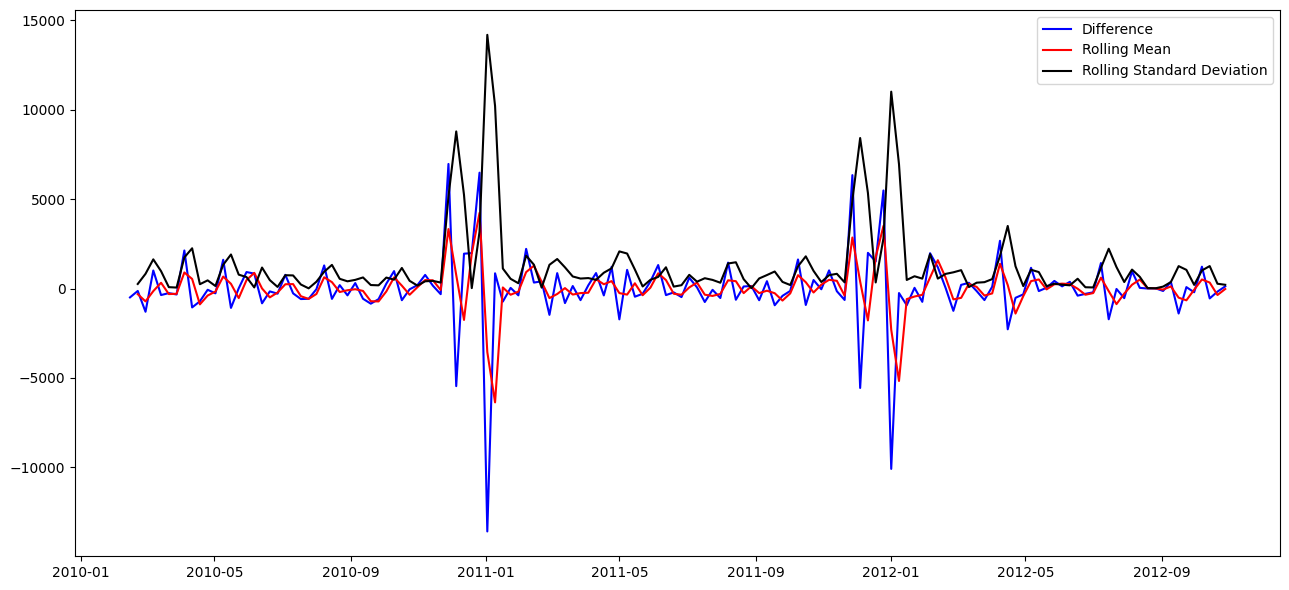

In [252]:
# taking mean and std of differenced data
diff_roll_mean = df_week_diff.rolling(window=2, center=False).mean()
diff_roll_std = df_week_diff.rolling(window=2, center=False).std()

fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_diff, color='blue',label='Difference')
ax.plot(diff_roll_mean, color='red', label='Rolling Mean')
ax.plot(diff_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

2.Log

In [253]:
logged_week = np.log1p(df_week['Weekly_Sales']).dropna() #taking log of data

In [254]:
log_roll_mean = logged_week.rolling(window=2, center=False).mean()
log_roll_std = logged_week.rolling(window=2, center=False).std()

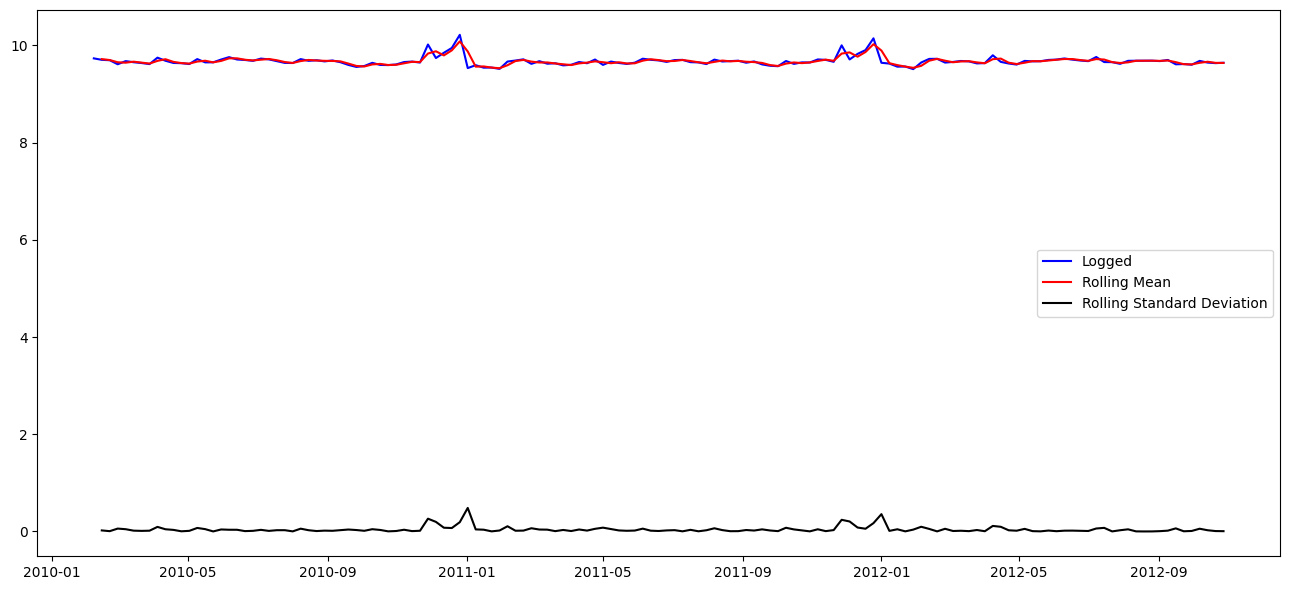

In [255]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(logged_week, color='blue',label='Logged')
ax.plot(log_roll_mean, color='red', label='Rolling Mean')
ax.plot(log_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

Difference version of data gave best results. So, I decided to take difference and use this data

Auto-ARIMA MODEL

In [256]:
train_data_diff = df_week_diff [:int(0.7*(len(df_week_diff )))]
test_data_diff = df_week_diff [int(0.7*(len(df_week_diff ))):]

In [257]:
import warnings
warnings.simplefilter("ignore")


In [258]:
# train_data = train_data['Weekly_Sales']
# test_data = test_data['Weekly_Sales']

model_auto_arima = auto_arima(train_data_diff, trace=True,start_p=0, start_q=0, start_P=0, start_Q=0,
                  max_p=20, max_q=20, max_P=20, max_Q=20, seasonal=True,maxiter=200,
                  information_criterion='aic',stepwise=False, suppress_warnings=True, D=1, max_D=10,
                  error_action='ignore',approximation = False)
model_auto_arima.fit(train_data_diff)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1826.858, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1793.619, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1795.532, Time=0.04 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1804.051, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=1794.966, Time=0.03 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1801.215, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=1791.045, Tim

ARIMA(maxiter=200, order=(3, 0, 2), scoring_args={},
      seasonal_order=(0, 0, 0, 1), suppress_warnings=True)

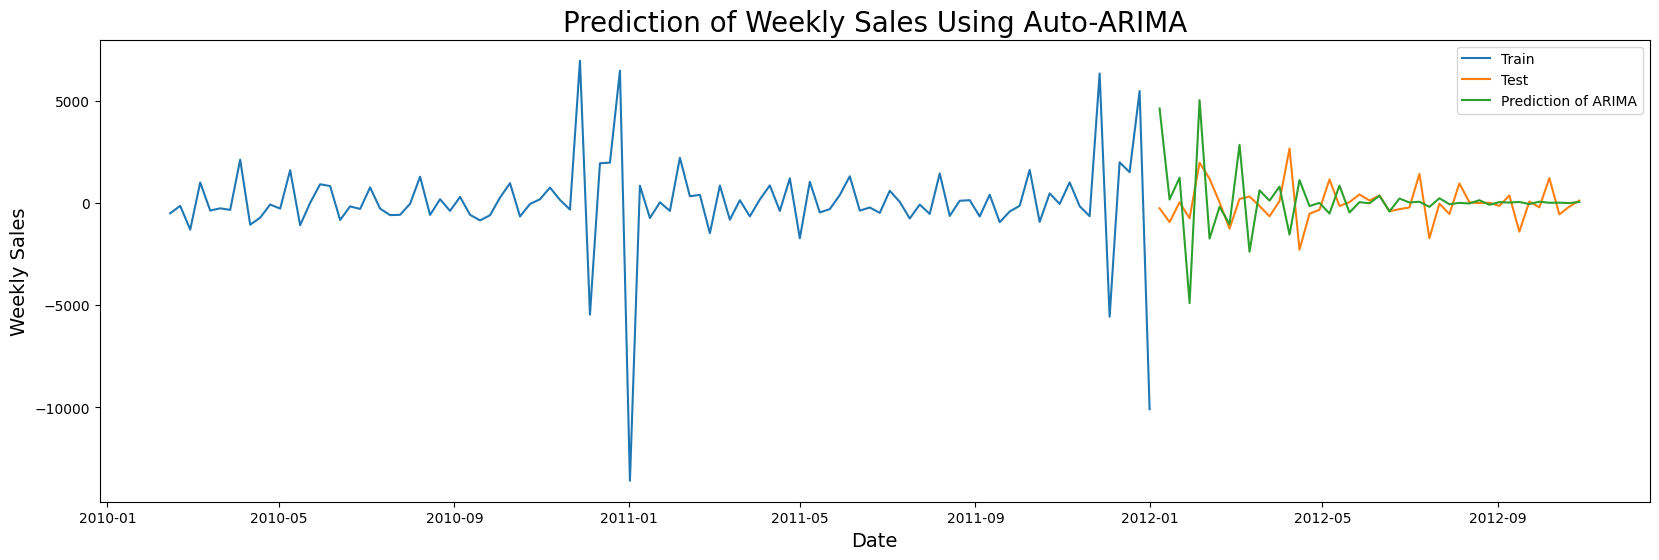

In [270]:
y_pred = model_auto_arima.predict(n_periods=len(test_data_diff))
# y_pred = pd.DataFrame(y_pred,index = test_data.index,columns=['Prediction'])
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales Using Auto-ARIMA', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction of ARIMA')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

In [271]:
wmae_test(test_data_diff, y_pred)

1187.6580682859123

ExponentialSmoothing

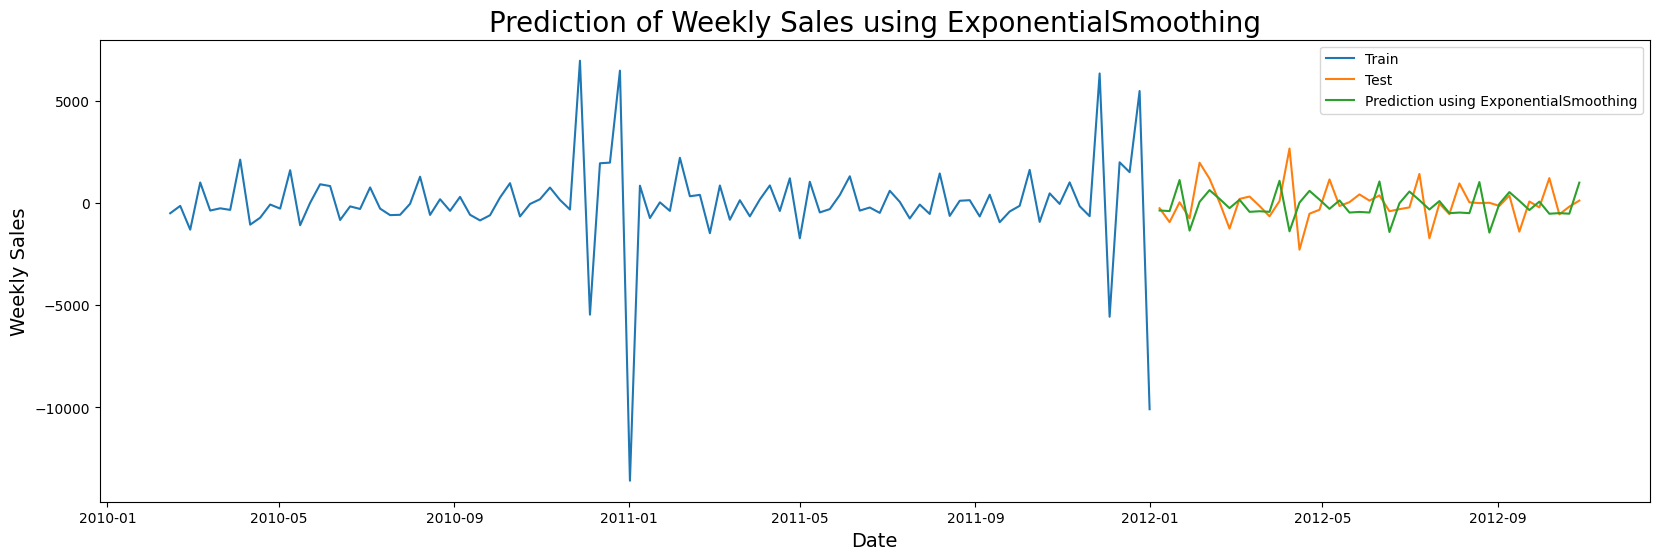

In [274]:
model_holt_winters = ExponentialSmoothing(train_data_diff, seasonal_periods=10, seasonal='additive',
                                           trend='additive',damped=True).fit() #Taking additive trend and seasonality.
y_pred = model_holt_winters.forecast(len(test_data_diff))# Predict the test data

#Visualize train, test and predicted data.
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales using ExponentialSmoothing', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction using ExponentialSmoothing')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

In [275]:
wmae_test(test_data_diff, y_pred)

751.7206665942015